In [26]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
import warnings
import random
from xgboost import XGBClassifier
import matplotlib.image as mpimg
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/heartbeat/ptbdb_abnormal.csv
/kaggle/input/heartbeat/ptbdb_normal.csv
/kaggle/input/heartbeat/mitbih_test.csv
/kaggle/input/heartbeat/mitbih_train.csv


In [4]:
train_df=pd.read_csv('../input/heartbeat/mitbih_train.csv',header=None)
test_df=pd.read_csv('../input/heartbeat/mitbih_test.csv',header=None)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cuda')

In [8]:
train_df.head()



,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
train_df.shape


(87554, 188)

In [49]:
train_df.columns

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            178, 179, 180, 181, 182, 183, 184, 185, 186, 187],
           dtype='int64', length=188)

In [51]:
train_df.dtypes

0      float64
1      float64
2      float64
3      float64
4      float64
        ...   
183    float64
184    float64
185    float64
186    float64
187    float64
Length: 188, dtype: object

In [53]:
train_df.describe

<bound method NDFrame.describe of             0         1         2         3         4         5         6    \
0      0.977941  0.926471  0.681373  0.245098  0.154412  0.191176  0.151961   
1      0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
2      1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   
3      0.925414  0.665746  0.541436  0.276243  0.196133  0.077348  0.071823   
4      0.967136  1.000000  0.830986  0.586854  0.356808  0.248826  0.145540   
...         ...       ...       ...       ...       ...       ...       ...   
87549  0.807018  0.494737  0.536842  0.529825  0.491228  0.484211  0.456140   
87550  0.718333  0.605000  0.486667  0.361667  0.231667  0.120000  0.051667   
87551  0.906122  0.624490  0.595918  0.575510  0.530612  0.481633  0.444898   
87552  0.858228  0.645570  0.845570  0.248101  0.167089  0.131646  0.121519   
87553  0.901506  0.845886  0.800695  0.748552  0.687138  0.599073  0.512167   

            7    

In [52]:
train_df.index

RangeIndex(start=0, stop=87554, step=1)

In [55]:
filter_large = train_df[187] == 1.0
train_df.loc[filter_large]


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
72471,1.000000,0.666667,0.100457,0.036530,0.073059,0.050228,0.018265,0.105023,0.132420,0.091324,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.0
72472,0.983696,1.000000,0.331522,0.000000,0.108696,0.163043,0.130435,0.190217,0.288043,0.222826,...,0.461957,0.483696,0.500000,0.494565,0.510870,0.51087,0.505435,0.472826,0.434783,1.0
72473,1.000000,0.911504,0.216814,0.000000,0.101770,0.199115,0.176991,0.194690,0.252212,0.238938,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.0
72474,0.090498,0.126697,0.217195,0.361991,0.461538,0.556561,0.443439,0.434389,0.452489,0.511312,...,0.122172,0.131222,0.140271,0.158371,0.176471,0.20362,0.212670,0.000000,0.000000,1.0
72475,0.961111,1.000000,0.551852,0.101852,0.040741,0.085185,0.094444,0.088889,0.085185,0.070370,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74689,1.000000,0.917073,0.253659,0.000000,0.092683,0.185366,0.165854,0.239024,0.278049,0.185366,...,0.375610,0.380488,0.356098,0.346341,0.370732,0.40000,0.375610,0.380488,0.400000,1.0
74690,0.014837,0.130564,0.213650,0.311573,0.430267,0.548961,0.664688,0.700297,0.721068,0.718101,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.0
74691,1.000000,0.895735,0.199052,0.000000,0.052133,0.052133,0.042654,0.104265,0.203791,0.194313,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.0
74692,0.904059,0.808118,0.195572,0.000000,0.081181,0.114391,0.147601,0.225092,0.177122,0.136531,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.0


In [89]:
sum_of_rows1 = train_df.iloc[72471:74693+1, :].sum().sum()
sum_of_rows1

83192.54310686002

In [90]:
std1 = sum_of_rows1 / 2223
std1

37.42354615693208

In [74]:
filter_large = train_df[187] == 0.0
train_df.loc[filter_large]

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72466,0.997151,0.888889,0.538462,0.051282,0.113960,0.267806,0.390313,0.404558,0.421652,0.435897,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72467,0.966667,0.842424,0.175758,0.000000,0.133333,0.224242,0.239394,0.251515,0.248485,0.257576,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72468,0.925000,0.685714,0.000000,0.062500,0.042857,0.094643,0.116071,0.130357,0.125000,0.139286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72469,0.930091,0.942249,0.389058,0.000000,0.217325,0.328267,0.297872,0.281155,0.290274,0.296353,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
sum_of_rows0 = train_df.iloc[0:72470+1, :].sum().sum()
sum_of_rows0

2194032.149697081

In [92]:
std0 = sum_of_rows1 / 72471
std0

1.1479425302101531

In [75]:
filter_large = train_df[187] == 2.0
train_df.loc[filter_large]

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
74694,0.000000,0.009756,0.074390,0.162195,0.240244,0.291463,0.370732,0.442683,0.498780,0.560976,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
74695,1.000000,0.865672,0.660448,0.458955,0.242537,0.126866,0.164179,0.242537,0.298507,0.350746,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
74696,0.556728,0.530343,0.440633,0.290237,0.171504,0.055409,0.005277,0.042216,0.000000,0.013193,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
74697,1.000000,0.968031,0.782609,0.512788,0.418159,0.381074,0.347826,0.320972,0.312020,0.295396,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
74698,0.000000,0.037681,0.101449,0.215942,0.236232,0.349275,0.389855,0.485507,0.539130,0.601449,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80477,0.984199,0.975169,0.880361,0.848758,0.794582,0.753950,0.715576,0.584650,0.336343,0.194131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
80478,0.528846,0.455128,0.285256,0.000000,0.022436,0.054487,0.080128,0.064103,0.086538,0.064103,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
80479,0.930921,0.927632,0.690789,0.250000,0.000000,0.021382,0.087171,0.125000,0.215461,0.302632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
80480,0.996124,0.997416,0.830749,0.534884,0.450904,0.408269,0.369509,0.355297,0.342377,0.337209,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [76]:
filter_large = train_df[187] == 3.0
train_df.loc[filter_large]

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
80482,1.000000,0.899749,0.641604,0.314536,0.101504,0.107769,0.111529,0.071429,0.063910,0.058897,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
80483,0.732252,1.000000,0.983773,0.484787,0.178499,0.111562,0.081136,0.050710,0.046653,0.046653,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
80484,0.991984,1.000000,0.601202,0.280561,0.158317,0.146293,0.104208,0.090180,0.080160,0.070140,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
80485,0.778378,0.528378,0.258108,0.128378,0.000000,0.037838,0.167568,0.235135,0.227027,0.222973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
80486,1.000000,0.914931,0.531250,0.303819,0.178819,0.157986,0.128472,0.126736,0.118056,0.111111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81118,0.771529,1.000000,0.776801,0.316344,0.165202,0.124780,0.117750,0.108963,0.084359,0.091388,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
81119,0.590000,0.373333,0.283333,0.303333,0.340000,0.263333,0.136667,0.120000,0.090000,0.110000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
81120,1.000000,0.939286,0.553571,0.285714,0.166071,0.141071,0.112500,0.108929,0.094643,0.096429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
81121,1.000000,0.964981,0.778210,0.513619,0.214008,0.090791,0.112840,0.097276,0.075227,0.070039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [77]:
filter_large = train_df[187] == 4.0
train_df.loc[filter_large]

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
81123,0.712610,0.629032,0.527859,0.414956,0.284457,0.164223,0.080645,0.032258,0.000000,0.016129,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
81124,1.000000,0.484848,0.541667,0.526515,0.522727,0.507576,0.496212,0.412879,0.284091,0.140152,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
81125,0.584046,0.500000,0.424501,0.324786,0.233618,0.128205,0.049858,0.000000,0.000000,0.028490,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
81126,1.000000,0.936170,0.878598,0.813517,0.727159,0.607009,0.496871,0.365457,0.272841,0.232791,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
81127,0.680412,0.584192,0.491409,0.379725,0.269759,0.149485,0.072165,0.012027,0.000000,0.012027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87551,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87552,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


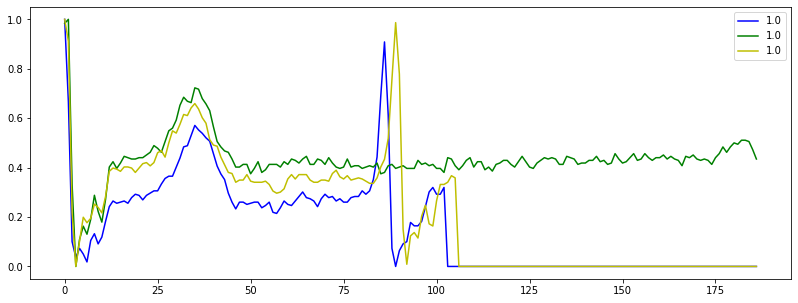

In [11]:
plt.figure(figsize=(30,5))

colors = ['r', 'b', 'g', 'y', 'k']

for i in range(72471, 72474):
    plt.subplot(121)
    test_row_1=np.array(train_df.iloc[i])
    plt.plot(test_row_1[:-1],label=test_row_1[-1],color=colors[i%5])
    plt.legend()

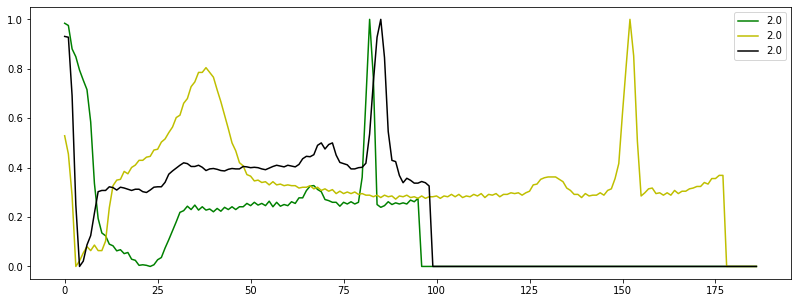

In [12]:
plt.figure(figsize=(30,5))

colors = ['r', 'b', 'g', 'y', 'k']

for i in range(80477, 80480):
    plt.subplot(121)
    test_row_1=np.array(train_df.iloc[i])
    plt.plot(test_row_1[:-1],label=test_row_1[-1],color=colors[i%5])
    plt.legend()

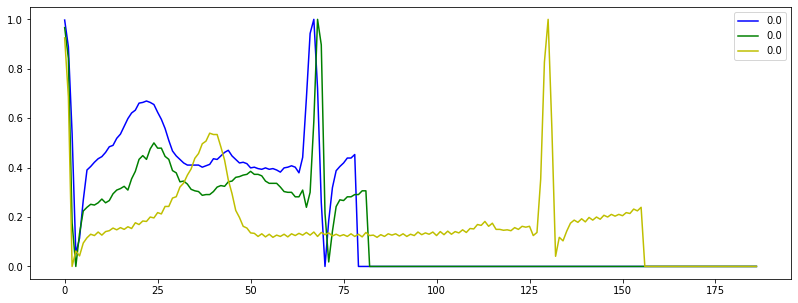

In [13]:
plt.figure(figsize=(30,5))

colors = ['r', 'b', 'g', 'y', 'k']

for i in range(72466, 72469):
    plt.subplot(121)
    test_row_1=np.array(train_df.iloc[i])
    plt.plot(test_row_1[:-1],label=test_row_1[-1],color=colors[i%5])
    plt.legend()

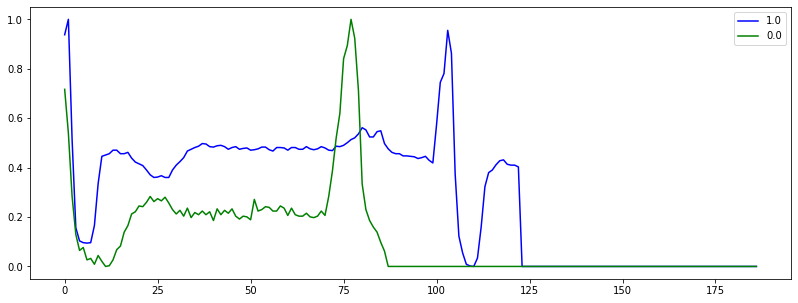

In [16]:
plt.figure(figsize=(30,5))
plt.subplot(121)
test_row_1=np.array(train_df.iloc[74688])
plt.plot(test_row_1[:-1],label=test_row_1[-1],color=colors[1])
plt.legend()
plt.subplot(121)
test_row_1=np.array(train_df.iloc[7])
plt.plot(test_row_1[:-1],label=test_row_1[-1],color=colors[2])
plt.legend()

In [ ]:
test_df

In [18]:
X_train= train_df.loc[:,:186]
y_train=np.array(train_df.loc[:,187:])
X_train.shape,y_train.shape

((87554, 187), (87554, 1))

In [19]:
X_test= test_df.loc[:,:186]
y_test=np.array(test_df.loc[:,187:])
X_test.shape,y_test.shape

((21892, 187), (21892, 1))

In [20]:
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)
y_pred=log_reg.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.91174858395761


In [40]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred=rf.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.9743285218344601


In [ ]:
# clf = svm.SVC(kernel='linear') 

# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)

# print(accuracy_score(y_test, y_pred))
